<a href="https://colab.research.google.com/github/IT24102008/PG151MLProject/blob/IT24102181/IT24102181.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Initial Model**

In [3]:
import pandas as pd
df = pd.read_csv('/content/preprocessed_stroke_data.csv')
display(df.head())

X = df.drop('stroke', axis=1)
y = df['stroke']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

import xgboost as xgb

xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

,0,1,2,3,4,5,6,7,8,9,stroke
0,2.305606,1.264816,0.250546,-0.430617,0.834524,0.333307,0.320894,-0.643058,-0.062396,-0.212238,1
1,1.453986,1.647613,-0.484745,0.160239,-1.163737,-0.412336,-0.231320,0.114952,0.208955,-0.247852,1
2,1.571330,-0.416363,-0.638432,0.597845,0.169697,-0.612380,0.748779,0.043821,-0.296528,-0.280570,1
3,1.537974,1.474840,0.641771,0.057266,0.514872,0.671681,-0.587822,0.692612,0.170372,-0.125929,1
4,1.642192,1.709071,-1.520156,0.258872,-1.103096,-0.424797,-0.188216,0.153761,-0.201548,0.639121,1


Shape of X_train: (4088, 10)
Shape of X_test: (1022, 10)
Shape of y_train: (4088,)
Shape of y_test: (1022,)
Accuracy: 0.9344
Precision: 0.2727
Recall: 0.0484
F1-score: 0.0822


### **Revised Model**

Class distribution in y:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64
Shape of X_train: (4088, 10)
Shape of X_test: (1022, 10)
Shape of y_train: (4088,)
Shape of y_test: (1022,)
Cross-validated recall: 0.9956 ± 0.0024
Test set metrics:
Accuracy: 0.8679
Precision: 0.1171
Recall: 0.2600
F1-score: 0.1615


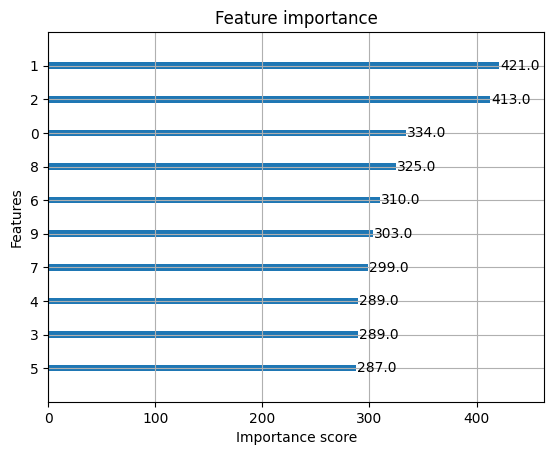

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load data
df = pd.read_csv('/content/preprocessed_stroke_data.csv')
print("Class distribution in y:")
print(df['stroke'].value_counts(normalize=True))

# Split data
X = df.drop('stroke', axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train XGBoost with class weights
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Cross-validation
scores = cross_val_score(xgb_model, X_train_smote, y_train_smote, cv=5, scoring='recall')
print(f"Cross-validated recall: {scores.mean():.4f} ± {scores.std():.4f}")

# Evaluate on test set
y_pred = xgb_model.predict(X_test)
print("Test set metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# Feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model)
plt.show()

### **Revised Model 02**

Class distribution in y:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64
Shape of X_train: (4088, 10)
Shape of X_test: (1022, 10)
Shape of y_train: (4088,)
Shape of y_test: (1022,)
Stratified CV recall: 0.9976 ± 0.0013
Test set metrics (default threshold):
Accuracy: 0.8160
Precision: 0.1443
Recall: 0.5600
F1-score: 0.2295

Threshold 0.2:
Precision: 0.1218
Recall: 0.5800
F1-score: 0.2014

Threshold 0.3:
Precision: 0.1318
Recall: 0.5800
F1-score: 0.2148

Threshold 0.4:
Precision: 0.1386
Recall: 0.5600
F1-score: 0.2222


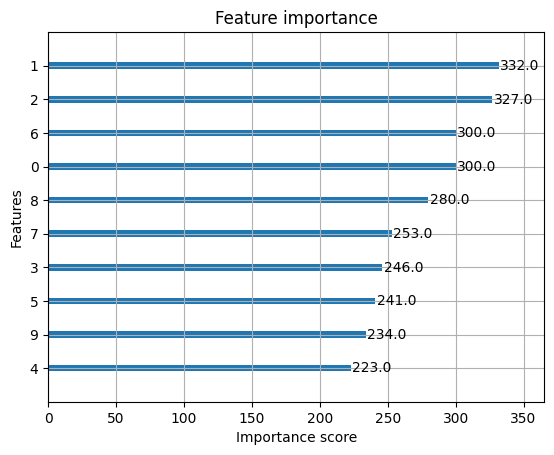

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.combine import SMOTEENN
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/preprocessed_stroke_data.csv')
print("Class distribution in y:")
print(df['stroke'].value_counts(normalize=True))

# Split data
X = df.drop('stroke', axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)

# Train XGBoost with class weights
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train_smoteenn, y_train_smoteenn)

# Stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_train_smoteenn, y_train_smoteenn, cv=skf, scoring='recall')
print(f"Stratified CV recall: {scores.mean():.4f} ± {scores.std():.4f}")

# Evaluate on test set
y_pred = xgb_model.predict(X_test)
print("Test set metrics (default threshold):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# Threshold tuning
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
thresholds = [0.2, 0.3, 0.4]
for thresh in thresholds:
    y_pred_adjusted = (y_pred_proba >= thresh).astype(int)
    print(f"\nThreshold {thresh}:")
    print(f"Precision: {precision_score(y_test, y_pred_adjusted):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_adjusted):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred_adjusted):.4f}")

# Feature importance
xgb.plot_importance(xgb_model)
plt.show()

### **Revised Model 03**

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:51:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters: {'model__subsample': 0.9, 'model__scale_pos_weight': np.float64(29.314070351758794), 'model__n_estimators': 300, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.9}

Classification Report:
              precision    recall  f1-score   support

           0     0.9758    0.7891    0.8726       972
           1     0.1314    0.6200    0.2168        50

    accuracy                         0.7808      1022
   macro avg     0.5536    0.7045    0.5447      1022
weighted avg     0.9345    0.7808    0.8405      1022

ROC-AUC: 0.7702


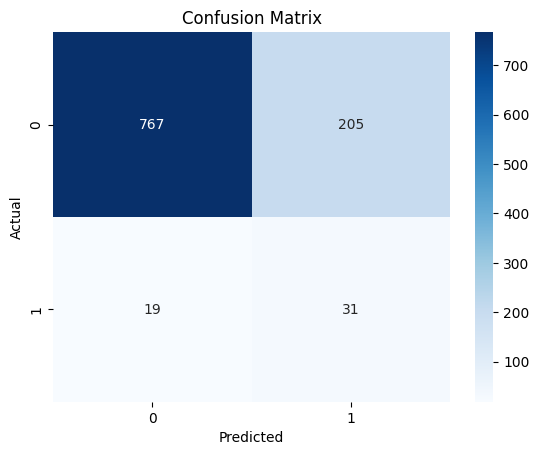

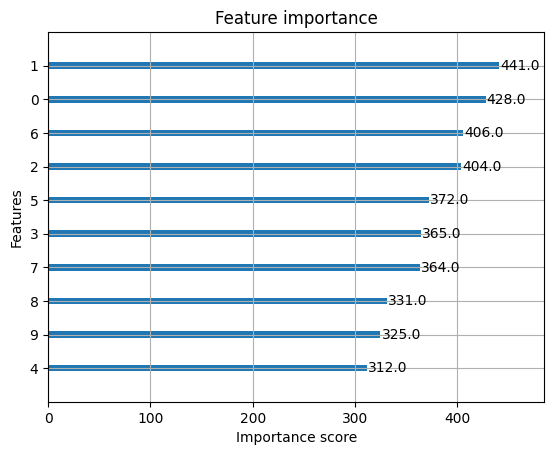

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/content/preprocessed_stroke_data.csv')

X = df.drop('stroke', axis=1)
y = df['stroke']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define pipeline
pipeline = Pipeline([
    ('sampling', SMOTEENN(random_state=42)),
    ('model', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Compute scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Hyperparameter grid
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__scale_pos_weight': [scale_pos_weight, scale_pos_weight * 0.5, scale_pos_weight * 1.5]
}

# Stratified KFold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search for best hyperparameters
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    n_jobs=-1,
    cv=skf,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

print("\nBest Parameters:", search.best_params_)

# Evaluate
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
xgb.plot_importance(best_model.named_steps['model'])
plt.show()


### **Revised Model 04**

Class distribution in y:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64
Train/Test split: (4088, 10) (1022, 10)
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best Parameters: {'model__subsample': 0.9, 'model__scale_pos_weight': np.float64(29.314070351758794), 'model__n_estimators': 300, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.9}

📊 Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0     0.9758    0.7891    0.8726       972
           1     0.1314    0.6200    0.2168        50

    accuracy                         0.7808      1022
   macro avg     0.5536    0.7045    0.5447      1022
weighted avg     0.9345    0.7808    0.8405      1022

ROC-AUC: 0.7702

🎯 Best Threshold for F1-score: 0.798
Best F1-score at that threshold: 0.2489

🚀 Optimized Classification Report:
              precision    recall  f1-score   support

           0 

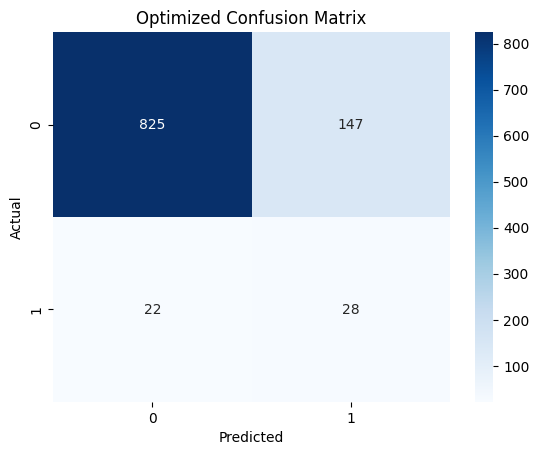

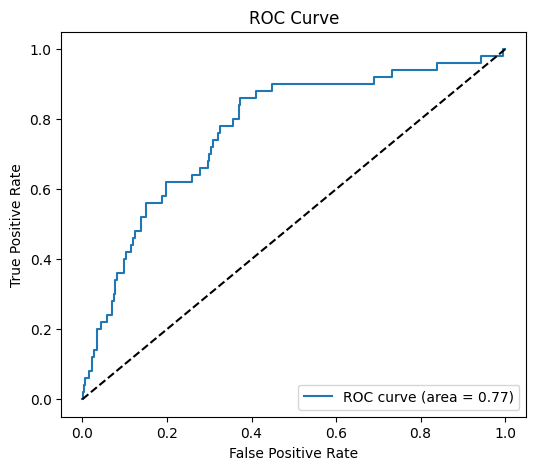

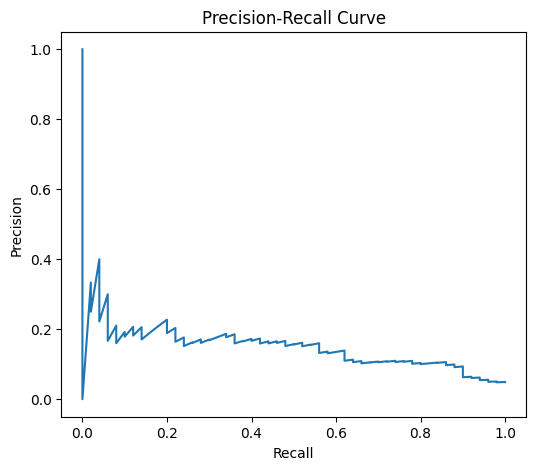

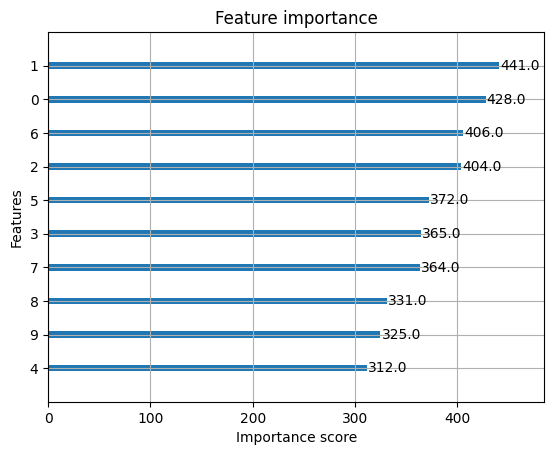

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
import xgboost as xgb

# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv('/content/preprocessed_stroke_data.csv')

X = df.drop('stroke', axis=1)
y = df['stroke']

print("Class distribution in y:")
print(y.value_counts(normalize=True))

# ==============================
# 2. Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train/Test split:", X_train.shape, X_test.shape)

# ==============================
# 3. Define Pipeline with SMOTEENN + XGBoost
# ==============================
pipeline = Pipeline([
    ('sampling', SMOTEENN(random_state=42)),
    ('model', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    ))
])

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__scale_pos_weight': [
        scale_pos_weight,
        scale_pos_weight * 0.5,
        scale_pos_weight * 1.5
    ]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    n_jobs=-1,
    cv=skf,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

print("\n✅ Best Parameters:", search.best_params_)

# ==============================
# 4. Evaluate Default Threshold (0.5)
# ==============================
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report (Threshold = 0.5):")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# ==============================
# 5. Find Best Threshold (Safe F1 Computation)
# ==============================
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute F1 safely (avoid division by zero)
f1_scores = 2 * (precisions * recalls) / np.where(
    (precisions + recalls) == 0, 1, (precisions + recalls)
)
f1_scores = np.nan_to_num(f1_scores)

# Get best threshold (ignore last precision point)
best_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n🎯 Best Threshold for F1-score: {best_threshold:.3f}")
print(f"Best F1-score at that threshold: {best_f1:.4f}")

# ==============================
# 6. Evaluate Optimized Threshold
# ==============================
y_pred_opt = (y_pred_proba >= best_threshold).astype(int)

print("\n🚀 Optimized Classification Report:")
print(classification_report(y_test, y_pred_opt, digits=4))

# ==============================
# 7. Confusion Matrix
# ==============================
cm = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Optimized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ==============================
# 8. ROC & Precision-Recall Curves
# ==============================
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ==============================
# 9. Feature Importance
# ==============================
xgb.plot_importance(best_model.named_steps['model'])
plt.show()
